
# Sleep Spindle Study

## Building Model

In this notebook, we build a model to detect the presence of sleep spindles in EEG data. This is a critical step in sleep analysis as sleep spindles are characteristic features of certain sleep stages.
        


## Imports

We will import the necessary libraries that are needed for processing the data, building the model, and evaluating its performance.
        

In [3]:

import mne
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import json
import utils
import feature_extraction
import data_preparation
        

### Download data

Using the `processed_data` function from the previous step to download our concatenated raw with its correspondent preprocessing and features.

In [ ]:
X, labels = data_preparation.processed_data(["dataset/train_S002_night1_hackathon_raw.mat",
                                            "dataset/train_S003_night5_hackathon_raw.mat"],
                                            ["dataset/train_S002_labeled.csv",
                                            "dataset/train_S003_labeled.csv"],
                                            labels=["SSO", "SS1"], fmin=11, fmax=15)
        


#### Model

The chosen model is an LSTM, since we are dealing with timeframes, LSTM are known to deal well with time depending samples. A k-cross validation is implemented, partitioning the data into 5 parts and alterning between the 4 parts for training and the 1 for testing.
        

In [ ]:
fold_no = 1
for train, test in KFold.split(X, labels):
    # Define the model architecture
    model = Sequential()
    model.add(LSTM(50, input_shape=(X[train].shape[1], X[train].shape[2]), return_sequences=True))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(20, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(20))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Generate class weights for current split
    class_weights = compute_class_weight('balanced', classes=np.unique(labels[train]), y=labels[train])
    class_weight_dict = dict(enumerate(class_weights))

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    
    # Fit data to model
    history = model.fit(X[test], labels[test], epochs=50, validation_split=0.2, class_weight=class_weight_dict, callbacks=[early_stopping])

    perf_metrics = utils.evaluate_model(model, X[test], labels[test])
    utils.save_model(model, history, perf_metrics, fold_no)
    # Increase fold number for next split
    fold_no = fold_no + 1
        

### Visualize plots and metrics

Determining the performance of the model

Plot accuracies and loss for training and validation

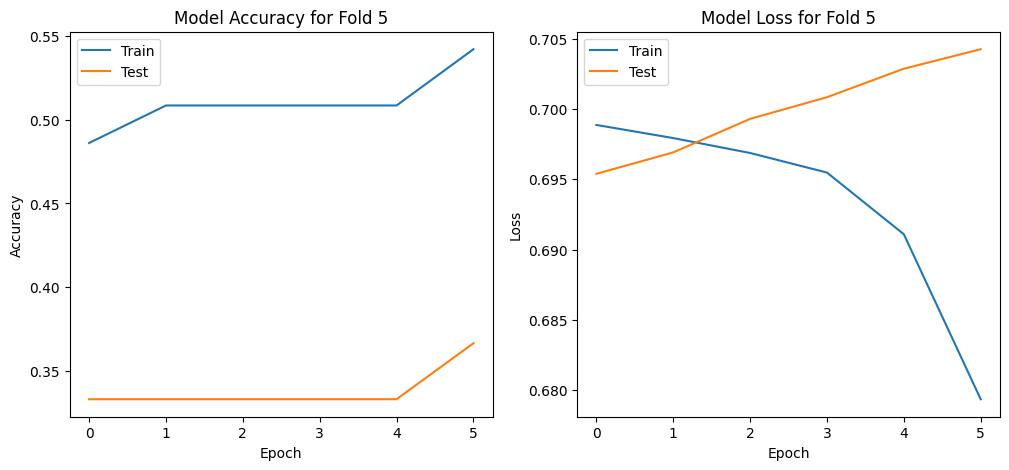

In [21]:
# filename = "SS_bp4_35Pre_0Features_LSTM_"
# filename = "SS_0Pre_0Features_LSTM_"
# filename = "SS_detrend_Pre_0Features_LSTM_"
# filename = "SS_bp11_15Pre_0Features_LSTM_"
# filename = "SS_VDM1_3Pre_0Features_LSTM_"
# filename = "SS_detrend_Pre_1Features_LSTM_"
utils.plot_fold_history(filename, 5)

Performance of each fold will be printed along with the average performance of the cross validation

In [22]:
performance = utils.print_performances(filename, 5)
print(performance)

      Fold  Accuracy  Precision  Recall  F1 Score
0   Fold 1      0.62       0.56    0.69      0.62
1   Fold 2      0.83       0.74    0.96      0.84
2   Fold 3      0.48       0.48    1.00      0.65
3   Fold 4      0.44       0.44    1.00      0.62
4   Fold 5      0.47       0.47    1.00      0.64
5  Average      0.57       0.54    0.93      0.67
